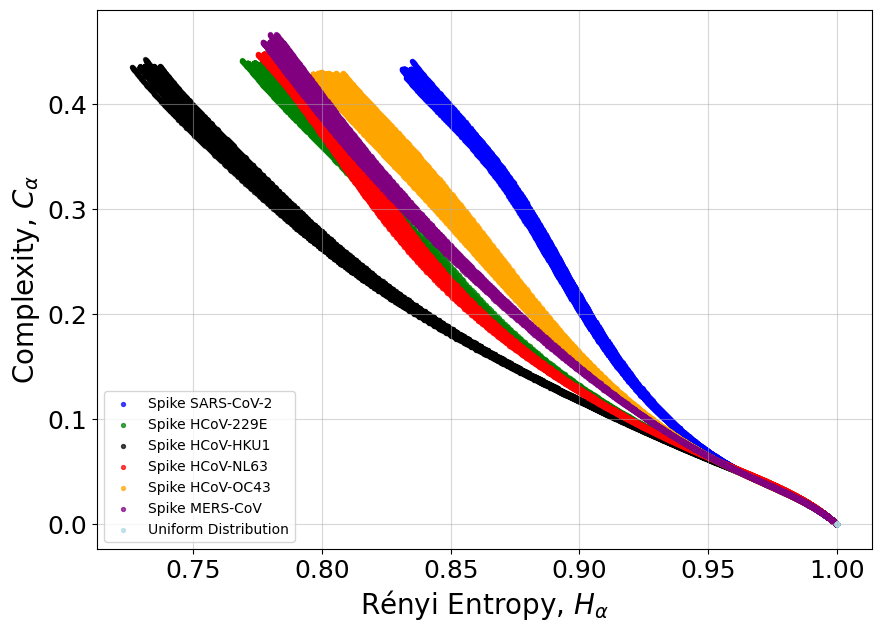

In [2]:
# Importation of essential libraries
import math  # Imports the math module for mathematical operations
import warnings  # Imports warnings to display or suppress messages
import numpy as np  # Imports NumPy for array manipulation and numerical calculations
import pandas as pd  # Imports Pandas for data table manipulation
import matplotlib.pyplot as plt  # Imports Matplotlib for generating graphs

def renyi_entropy(data, k, alpha=1):
    """
    Computes Rényi entropy for a given set of probabilities.
    
    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible categories.
    - alpha: float or array-like, Rényi entropy parameter.
    
    Returns:
    - s: value (or array) of normalized Rényi entropy.
    """

    probabilities = np.asarray(data)  # Converts 'data' into a NumPy array.
    probabilities = probabilities[probabilities > 0]  # Removes zero values to avoid log(0), which is undefined.

    smax = np.log2(float(k))  # Computes the maximum possible entropy for normalization.

    # Checks if alpha is a list, tuple, or array to compute multiple entropy values
    if isinstance(alpha, (tuple, list, np.ndarray)):
        s = []  # Initializes a list to store entropy results.

        # Loop to compute Rényi entropy for each alpha value
        for alpha_ in alpha:
            if alpha_ != 1:  
                # Rényi entropy formula for alpha ≠ 1:
                s += [(1 / (1 - alpha_)) * np.log2(np.sum(probabilities**alpha_)) / smax]
            else:
                # Special case: Shannon entropy (when alpha = 1)
                s += [-np.sum(probabilities * np.log2(probabilities)) / smax]

        s = np.asarray(s)  # Converts the list into a NumPy array for easier manipulation.

    else:  # If alpha is a single value, compute directly without looping.
        if alpha != 1:
            # Rényi entropy formula for a single alpha ≠ 1:
            s = (1 / (1 - alpha)) * np.log2(np.sum(probabilities**alpha)) / smax
        else:
            # Special case: Shannon entropy (when alpha = 1)
            s = -np.sum(probabilities * np.log2(probabilities)) / smax

    return s  # Returns the computed entropy (normalized by the maximum entropy).

# Main function to compute Rényi complexity-entropy
def renyi_complexity_entropy(data, k, alpha=1):
    """
    Computes Rényi entropy and complexity for a given set of probabilities.

    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible categories.
    - alpha: float or array-like, Rényi entropy parameter.

    Returns:
    - Array with normalized entropy and complexity.
    """

    # Auxiliary function to compute the maximum Jensen-Rényi divergence
    def jensen_renyi_divergence_max(n_states, q):
        if q == 1:  # Special case for Shannon entropy
            return (-0.5 * (((n_states + 1) / n_states) * np.log2(n_states + 1) + np.log2(n_states) - 2 * np.log2(2 * n_states)))
        else:  # General case for Rényi entropy with q ≠ 1
            return (
                (np.log2(((n_states + 1.)**(1. - q) + n_states - 1.) / (2.**(1. - q) * n_states)) + (1. - q) *
                 np.log2((n_states + 1.) / (2. * n_states))) / (2. * (q - 1))
            )

    n = float(k)  # Converts k to float to ensure precision in calculations

    probabilities = np.asarray(data)  # Converts 'data' into a NumPy array.
    probabilities = probabilities[probabilities != 0]  # Removes zero probabilities to avoid log(0).

    h_a = renyi_entropy(probabilities, k, alpha)  # Computes Rényi entropy for the given data.

    n_states_not_occur = n - len(probabilities)  # Computes the number of states that do not occur in the data.
    uniform_dist = 1 / n  # Defines the theoretical uniform distribution, assuming all states have equal probability.
    p = probabilities  # Assigns observed probabilities to variable p.

    # Checks if 'alpha' is a list, tuple, or array (in which case multiple values are analyzed)
    if isinstance(alpha, (tuple, list, np.ndarray)):
        jr_div = []  # Initializes list to store Jensen-Rényi divergence values.
        jr_div_max = []  # Initializes list to store maximum Jensen-Rényi divergence values.

        # Loop to compute divergence for each alpha value
        for alpha_ in alpha:
            if alpha_ == 1:  # Special case: Shannon entropy
                p_plus_u_over_2 = (uniform_dist + p) / 2  # Mean of observed and uniform distributions.

                # Computation of the three terms of Jensen-Shannon divergence
                s_of_p_plus_u_over_2 = -np.sum(p_plus_u_over_2 * np.log2(p_plus_u_over_2)) - (0.5 * uniform_dist) * np.log2(0.5 * uniform_dist) * n_states_not_occur
                s_of_p_over_2 = -np.sum(p * np.log2(p)) / 2  # Half of the entropy of the observed distribution.
                s_of_u_over_2 = np.log2(n) / 2.  # Half of the entropy of the uniform distribution.

                jr_div += [s_of_p_plus_u_over_2 - s_of_p_over_2 - s_of_u_over_2]  # Normalized Jensen-Shannon divergence.
            else:
                # Computation of Jensen-Rényi divergence
                first_term = ((p + uniform_dist) / 2)**(1 - alpha_)
                first_term = np.log2(np.sum(first_term * p**alpha_))

                second_term = np.log2(np.sum((1 / (n**alpha_)) * ((p + uniform_dist) / 2)**(1 - alpha_)) + (n_states_not_occur * (1 / n**alpha_) * (1 / (2 * n))**(1 - alpha_)))

                jr_div += [(1 / (2 * (alpha_ - 1))) * (first_term + second_term)]

            jr_div_max += [jensen_renyi_divergence_max(n, alpha_)]  # Computes the maximum divergence for each alpha.

        jr_div = np.asarray(jr_div)  # Converts list into NumPy array.
        jr_div_max = np.asarray(jr_div_max)  # Converts list into NumPy array.

    else:  # If alpha is a single value, compute directly without looping.
        if alpha == 1:
            p_plus_u_over_2 = (uniform_dist + p) / 2  # Mean of observed and uniform distributions.

            # Computation of the three terms of Jensen-Shannon divergence
            s_of_p_plus_u_over_2 = -np.sum(p_plus_u_over_2 * np.log2(p_plus_u_over_2)) - (0.5 * uniform_dist) * np.log2(0.5 * uniform_dist) * n_states_not_occur
            s_of_p_over_2 = -np.sum(p * np.log2(p)) / 2  # Half of the entropy of the observed distribution.
            s_of_u_over_2 = np.log2(n) / 2.  # Half of the entropy of the uniform distribution.

            jr_div = s_of_p_plus_u_over_2 - s_of_p_over_2 - s_of_u_over_2  # Normalized Jensen-Shannon divergence.
        else:
            # Computation of Jensen-Rényi divergence
            first_term = ((p + uniform_dist) / 2)**(1 - alpha)
            first_term = np.log2(np.sum(first_term * p**alpha))

            second_term = np.log2(np.sum((1 / (n**alpha)) * ((p + uniform_dist) / 2)**(1 - alpha)) + (n_states_not_occur * (1 / n**alpha) * (1 / (2 * n))**(1 - alpha)))

            jr_div = (1 / (2 * (alpha - 1))) * (first_term + second_term)

        jr_div_max = jensen_renyi_divergence_max(n, alpha)  # Computes the maximum divergence for a single alpha value.

    # Returns an array with two columns:
    # 1st column: values of normalized Rényi entropy.
    # 2nd column: values of normalized complexity (ratio between divergence and maximum divergence).
    return np.asarray([h_a, h_a * jr_div / jr_div_max]).T

# List of Excel files containing probability distributions for different species
dist_prob_species = [
    "probabilities_Spike SARS-CoV-2.xlsx",
    "probabilities_Spike HCoV-229E.xlsx",
    "probabilities_Spike HCoV-HKU1.xlsx",
    "probabilities_Spike HCoV-NL63.xlsx",
    "probabilities_Spike HCoV-OC43.xlsx",
    "probabilities_Spike MERS-CoV.xlsx",
    "probabilities_Uniform Distribution.xlsx"  # Uniform distribution for comparison
]

# Define different colors for each file in the graph
colors = ['blue', 'green', 'black', 'red', 'orange', 'purple', 'lightblue']

# Set the figure size for the graph
plt.figure(figsize=(10, 7))

# Loop through each Excel file to process the data and generate the graphs
for i, file in enumerate(dist_prob_species):
    entropies = []  # List to store entropy values
    complexities = []  # List to store complexity values
    alpha_values = []  # List to store α (q) values

    try:
        # Read data from the Excel file
        df = pd.read_excel(file)

        # Check if the 'Sequence_ID' column exists in the file
        if "Sequence_ID" not in df.columns:
            raise KeyError(f"The column 'Sequence_ID' was not found in the file {file}")

        # Select the columns representing k-mer frequencies (ignoring 'Sequence_ID')
        kmer_columns = df.columns[1:]

        # Iterate through each row of the DataFrame (each sequence/protein)
        for index, row in df.iterrows():
            # Get the k-mer frequency values, removing NaN values
            p = row[kmer_columns].dropna().tolist()

            # Iterate over α (q) values varying logarithmically from 0.001 to 100
            for alpha in np.logspace(np.log10(0.001), np.log10(100), num=1000):
                try:
                    # Compute Rényi entropy and complexity for each α value
                    result = renyi_complexity_entropy(p, alpha=alpha, k=20)

                    # Unpack entropy and complexity values from the function return
                    entropy, complexity = result
                    entropies.append(entropy)
                    complexities.append(complexity)
                    alpha_values.append(alpha)
                except ValueError as e:
                    print(f"Error unpacking the result for alpha={alpha}: {e}")
                except Exception as e:
                    print(f"Error computing entropy and complexity for alpha={alpha}: {e}")

        # Plot the Entropy vs Complexity points for each Excel file
        plt.scatter(entropies, complexities, color=colors[i % len(colors)], s=8, alpha=0.7,
                    label=file.replace('probabilities_', '').replace('.xlsx', ''))

    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found. Check the file path and name.")
    except KeyError as e:
        print(e)

# Graph settings
plt.xticks(fontsize=18)  # Set the font size for X-axis values
plt.yticks(fontsize=18)  # Set the font size for Y-axis values
plt.xlabel("Rényi Entropy, $H_{\\alpha}$", fontsize=20)  # Set the label for the X-axis
plt.ylabel("Complexity, $C_{\\alpha}$", fontsize=20)  # Set the label for the Y-axis
plt.grid(True, linestyle='-', alpha=0.5)  # Add a grid to the graph for better visualization
plt.legend(fontsize=10, loc='lower left')  # Add a legend to differentiate each file in the graph

# Save the generated graph as an image file
plt.savefig('Rényi Complexity-Entropy graph (Amino Acids).png')

# Display the generated graph
plt.show()
